<a href="https://colab.research.google.com/github/ypzhangescp/project-yoda/blob/main/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1 import Session, get_variable, placeholder, truncated_normal_initializer, get_variable_scope
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
import cv2
import time
import matplotlib.pyplot as plt

In [90]:
!mv ../raw_data.zip .

mv: cannot stat '../raw_data.zip': No such file or directory


# New Section

In [ ]:
!unzip raw_data.zip

Archive:  raw_data.zip
   creating: raw_data/
  inflating: raw_data/.DS_Store      
   creating: raw_data/harry-potter/
  inflating: raw_data/harry-potter/.DS_Store  
   creating: raw_data/harry-potter/0002/
  inflating: raw_data/harry-potter/0002/002.jpg  
  inflating: raw_data/harry-potter/0002/003.jpg  
  inflating: raw_data/harry-potter/0002/001.jpg  
  inflating: raw_data/harry-potter/0002/004.jpg  
  inflating: raw_data/harry-potter/0002/010.jpg  
  inflating: raw_data/harry-potter/0002/011.jpg  
  inflating: raw_data/harry-potter/0002/005.jpg  
  inflating: raw_data/harry-potter/0002/013.jpg  
  inflating: raw_data/harry-potter/0002/007.jpg  
  inflating: raw_data/harry-potter/0002/006.jpg  
  inflating: raw_data/harry-potter/0002/012.jpg  
  inflating: raw_data/harry-potter/0002/008.jpg  
  inflating: raw_data/harry-potter/0002/009.jpg  
   creating: raw_data/harry-potter/0001/
  inflating: raw_data/harry-potter/0001/002.jpg  
  inflating: raw_data/harry-potter/0001/003.jpg  
 

In [88]:
base_path = f"raw_data"
index = pd.read_csv(f'{base_path}/index.csv')
metadata = pd.read_csv(f'{base_path}/metadata.csv')
df = pd.merge(index, metadata, on='class_id')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             361 non-null    object
 1   class_id         361 non-null    int64 
 2   lego_ids         361 non-null    object
 3   lego_names       361 non-null    object
 4   minifigure_name  361 non-null    object
dtypes: int64(1), object(4)
memory usage: 16.9+ KB


In [ ]:
pwd

'/content'

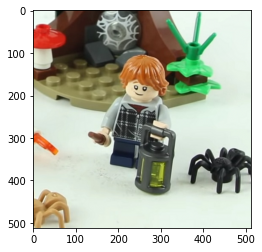

In [ ]:
image = cv2.imread('/content/raw_data/harry-potter/0002/009.jpg')
image = cv2.resize(image, (512,512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(image)

In [ ]:
index.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [ ]:
metadata.head()

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


In [ ]:
df = pd.merge(index, metadata[['class_id', 'minifigure_name']], on='class_id')
df

,path,class_id,minifigure_name
0,marvel/0001/001.jpg,1,SPIDER-MAN
1,marvel/0001/002.jpg,1,SPIDER-MAN
2,marvel/0001/003.jpg,1,SPIDER-MAN
3,marvel/0001/004.jpg,1,SPIDER-MAN
4,marvel/0001/005.jpg,1,SPIDER-MAN
...,...,...,...
356,star-wars/0016/005.jpg,37,OBI-WAN KENOBI
357,star-wars/0016/006.jpg,37,OBI-WAN KENOBI
358,star-wars/0016/007.jpg,37,OBI-WAN KENOBI
359,star-wars/0016/008.jpg,37,OBI-WAN KENOBI


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             361 non-null    object
 1   class_id         361 non-null    int64 
 2   minifigure_name  361 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.3+ KB


In [ ]:
print("Missing Data:",df.isnull().any().any())
df.isnull().sum()

Missing Data: False


path               0
class_id           0
minifigure_name    0
dtype: int64

In [ ]:
labels = df['minifigure_name'].unique()
count = df['minifigure_name'].value_counts()

In [ ]:
count

SPIDER-MAN                     18
R2-D2                          12
GENERAL GRIEVOUS               12
TRACKER TRAQUEUR RASTREADOR    12
LUKE SKYWALKER                 12
YODA                           12
OWEN GRADY                     12
TASKMASTER                     11
MACE WINDU                     11
HARRY POTTER                   11
BLACK WIDOW                    11
RON WEASLEY                    11
YELENA BELOVA                  11
VENOM                          10
EMPEROR PALPATINE              10
IRON MAN MK 41                 10
AUNT MAY                       10
CAPTAIN AMERICA                10
IRON MAN MK 50                 10
GHOST SPIDER                   10
IRON MAN MK 5                  10
OUTRIDER 1                     10
IRON MAN MK 1                  10
OUTRIDER 2                     10
OBI-WAN KENOBI                  9
ANAKIN SKYWALKER                9
DARTH VADER                     9
JANNAH                          8
HAN SOLO                        8
KYLO REN      

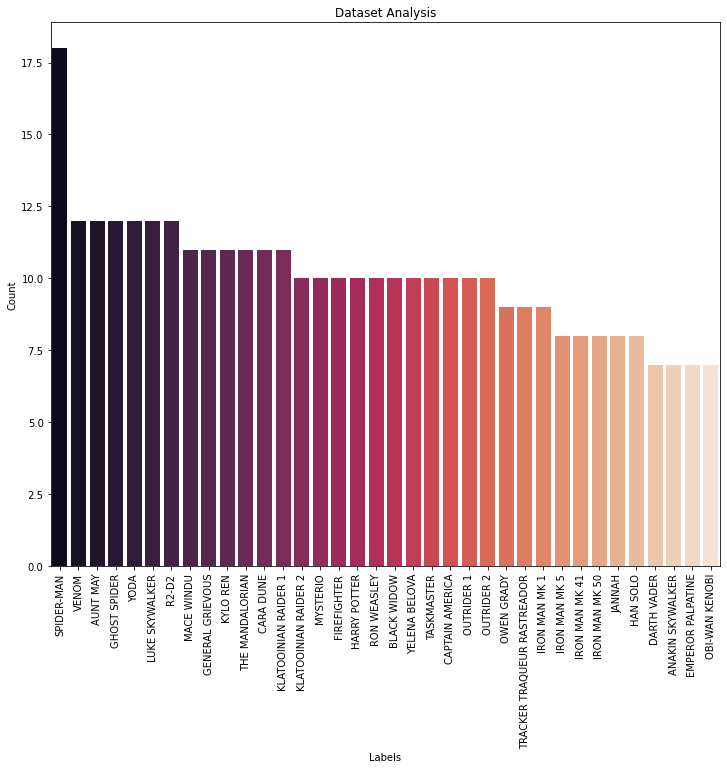

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.barplot(x=labels, y=count,palette="rocket")

plt.xticks(rotation= 90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Dataset Analysis')
plt.show()

In [ ]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [ ]:
def generator(z, batch_size, z_dim):
    g_w1 = get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=truncated_normal_initializer(stddev=0.02))
    g_b1 = get_variable('g_b1', [3136], initializer=truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.nn.batch_normalization(g1, variance_epsilon=1e-5)
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=truncated_normal_initializer(stddev=0.02))
    g_b2 = get_variable('g_b2', [z_dim/2], initializer=truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.nn.batch_normalization(g2, variance_epsilon=1e-5)
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=truncated_normal_initializer(stddev=0.02))
    g_b3 = get_variable('g_b3', [z_dim/4], initializer=truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.nn.batch_normalization(g3, variance_epsilon=1e-5)
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [ ]:
##Generating a sample image

In [89]:
with Session() as sess:
  z_dim = 100
  z = placeholder(tf.float32, [None, z_dim])
  generated_image_output = generator(z, 1, z_dim)
  z_batch = np.random.normal(0, 1, [1, z_dim])
  sess.run(tf.global_variables_initializer())
  generated_image = sess.run(generated_image_output,
                                feed_dict={z: z_batch})
  generated_image = generated_image.reshape([28, 28])
  plt.imshow(generated_image, cmap='Greys')

TypeError: ignored

In [91]:
##train a GAN

In [92]:
tf.reset_default_graph()
batch_size = 50

z = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

AttributeError: ignored